# Let's start with Multimodal Deep Archetypal Analysis 

### Archetypal Analysis

Archetypal Analysis is a technique in statistics and machine learning designed to uncover the extreme points within a dataset, termed archetypes. These archetypes represent the most distinct or extreme manifestations within the data space, suggesting that every data point can be approximated as a mixture of these archetypal forms. 
Given a dataset represented by the matrix $X$, where each row corresponds to a d-dimensional data point, the objective of archetypal analysis is to identify a matrix $A$, which encapsulates the archetypes, and a matrix $B$, which contains coefficients that express each data point in $X$ as convex combinations of the archetypes in $A$.

The core optimization challenge in archetypal analysis is to minimize the reconstruction error between the dataset $X$ and its approximation $ABX$, formally expressed as:

```{math}
\min_{A, B} \|X - ABX\|^2_F
```

subject to constraints for both $A$ and $B$ that ensure the convexity of the combinations, with $B_{ij} \geq 0$ for all elements to guarantee non-negativity, and $\sum_{j} B_{ij} = 1$ for all $i$, ensuring that the coefficients for each data point sum to one. 
Similarly, constraints are applied to $A$ to ensure its columns can be interpreted as mixtures of data points, hence $A_{ij} \geq 0$ and $\sum_{j} A_{ij} = 1$ for all $i$. 
These constraints ensure that each data point in $X$ is represented as a convex combination of archetypes, making the solution interpretable and reflective of the underlying structure of the dataset.



The original algorithm proposed by [Cutler and Breiman](https://www.tandfonline.com/doi/abs/10.1080/00401706.1994.10485840) is based on the idea of solving alternating interative least square problems. Namely, the algorithm operates iteratively, alternating between two main steps: updating coefficients B for a fixed set of archetypes $A$, and then updating $A$ given $B$. Initially, $A$ is populated with randomly selected data points. In each iteration, $B$ is updated to represent each data point as a convex combination of the current archetypes, and then $A$ is updated to better fit the data points based on the new coefficients. The process iterates until the change in $A$ between iterations, measured using the Frobenius norm $\|A_{new} - A_{old}\|_F$, falls below a predefined convergence threshold, or a maximum number of iterations is reached.

Let us first define some convenience function:

In [1]:
# Some code was taken/adapted from the amazing implementation in
# https://github.com/aleixalcacer/archetypes

import numpy as np
from scipy.optimize import nnls


def frobenius_norm_difference(M1, M2):
    """Compute the Frobenius norm of the difference between two matrices."""
    return np.linalg.norm(M1 - M2, 'fro')

def initialize_archetypes(X, k):
    """Randomly initialize archetypes."""
    
    # For A and B we just sample from a dirichlet distribution
    B = np.random.dirichlet(np.ones(X.shape[0]), k)
    A = np.random.dirichlet(np.ones(k), X.shape[0])
    
    return A, B

def optimize_nnls(M1,M2):
    
    # Add some constants to enforce the convexity of the final matrix
    M1 = np.pad(M1, ((0, 0), (0, 1)), "constant", constant_values=20)
    M2 = np.pad(M2, ((0, 0), (0, 1)), "constant", constant_values=20)
    res = np.empty((M1.shape[0], M2.shape[0]))
    
    # Solve the actual non-negative least square problem
    for j in range(res.T.shape[1]):
        res.T[:, j], _ = nnls(M2.T, M1.T[:, j])
    
    # Check convexity + remove nans
    res /= res.sum(1)[:, None]
    res[np.isnan(res)] = 1 / res.shape[1]
    return res

def update_archetypes(X, H):
    """Update archetypes Z for fixed coefficients."""
    return optimize_nnls(H,X)

def update_weights(X, H):
    """Update coefficients A for fixed archetypes"""
    return  optimize_nnls(X,H)

We then run the training loop and have a look at the results. For this example we choose a toy dataset of body measuremnts for 3 different species of penguins.

In [2]:
# code a function that performs archetypal analysis
def archetypal_analysis(X, k, max_iter=30, tol=1e-3):
    """Perform archetypal analysis."""
    A, B = initialize_archetypes(X, k)
    H = B @ X
    loss_old = None
    for _ in range(max_iter):
        A = update_weights(X, H)
        H = np.linalg.pinv(A) @ X
        B = update_archetypes(X, H)
        H = B @ X
        loss = frobenius_norm_difference(X, A @ H)
        if loss_old is not None and loss_old - loss < tol:
            break
    return A, B

In [3]:
import seaborn as sns

penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We will work with just 2 dimensions as it's easier to understand what is happening, but of course AA can be extended to inputs of arbitraty dimensions.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

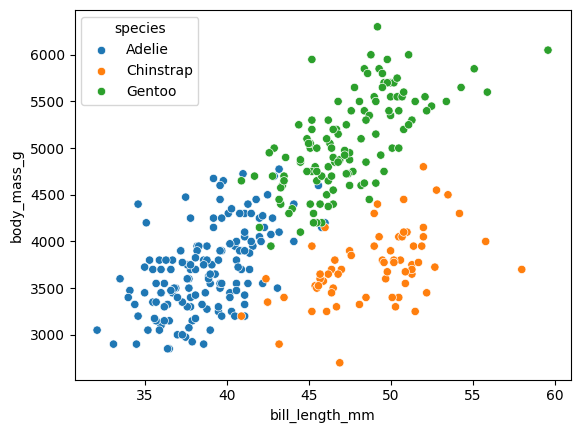

In [4]:

penguins =  penguins[~penguins['body_mass_g'].isna()]

sns.scatterplot(data=penguins, x="bill_length_mm", y="body_mass_g", hue="species")


In [5]:
# We standardize as it improves stability of the algorithm

X_df = penguins[["bill_length_mm", "body_mass_g"]]
X_df = (X_df-X_df.mean())/X_df.std()
X = X_df.values

A,B = archetypal_analysis(X,3, max_iter = 10)



As you can see the algorithm correctly fits a trangle across the 2D space of the data. The archetypes are the red points and the data points are colored by species. To give a bit of interpretation we have small penguins with a short bill, which are mainly represented by Adelie specie. Another archetype has low body mass and a long bill, while the last one his a big penguin with a somewhat long bill. The main point of archetypal analysis is that it gives us the possibility to reason continously by comparison to some extreme prototypes. It gives us a different look on our data compared to clustering and works very well when we have some continous process (be it differentiation or fitness optimization) underlying our data.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

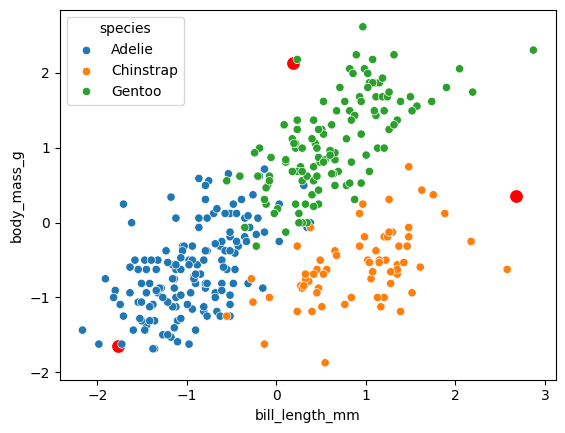

In [6]:
# Generate the archetypes
H = B @ X

X_df["species"] = penguins["species"]

# plot the archetypes together to this scatterplot in the same plots, and connect them by a triangle
sns.scatterplot(x=H[:,0], y=H[:,1], color='red', s=100)
sns.scatterplot(data=X_df, x="bill_length_mm", y="body_mass_g", hue="species")


### Why deep archetypal analysis? 

There are two main reasons why we would like to move from the standard analysis we saw before:
*   Better scaling properties 
*   Working in non-linear latent space

Let's briefly talk about them before looking at an implementation. Regarding the scaling behaviour of the classical algorithm we presented before, it is quite clear how it becomes quite slow for big input matrices as solving the non-negative least squares becomes expensive. Improvements on that have been proposed, like the use of the Frank-Wolf algorithm. Despite this, the idea of being able to express matrices A and B as a function of the input and the ability to optimize using classical SGD is certainly appealing for large datasets. Another important point is the space where to perform the AA. In our toy dataset we had only two features but of course in reality it commonly happens to work in very large spaces. What you tend to do is first perform dimensionality reduction for example with a PCA and then run the AA on the loadings of the PCA. Of course, real dataset can be very complicated and the idea of being able to use neural networks to both reduce the dimensionality in a non-linear way becomes a key component to get good results in real case scenarios. 

These two ideas converge in attempts to extend AA into the Deep Learning framework as in [Keller et al. 2019](https://doi.org/10.48550/arXiv.1901.10799). Initially we started from their idea and expanded it to multi-modal data, we then change the formulation of the model to improve on some aspects, but that's the topic of the next section, so no spoilers for now. Going back to Deep Archetypal Analysis the actual formulation is quite straightforward, as we said we want a neural network to learn the 2 matrices A and B as an arbitrary function of the data $f^\theta(X)$. The approach used is to fix a standard simplex in the latent space (let us call its vertices $Z^{\text{fixed}}$ and learn a mapping function from $X$ to this simplex with our network $f^\theta(X)$. If you think for a bit this is exactly equivalent to learn the matrix $A$ given as a set of archetypes $Z^{\text{fixed}}$ and our final reconstruction is nothing else but $Z^{*} = AZ^{\text{fixed}}$. We then reconstruct back the input using a decoder neural network that takes as input $Z^{*}$.

So what about $B$? How can we make sure that $Z$ is also a convex combination of our data points in latent space? A possible solution is to add a term in the loss. Namely, if you recall that the archetypes structure given the matrices above can be written as is $BAZ^{\text{fix}}$ we just have to force it to be equal to our latent simplex. We then add this term to the final loss.

```{math}
\ell=\left\|Z^{\text {fixed }}-B A Z^{\text {fixed }}\right\|_2^2=\left\|Z^{\text {fixed }}-Z^{\text {pred }}\right\|_2^2
```

The final loss is the usual ELBO of a Variational Autoencoder (please refer to the original paper and to [Kingma et al. 2013](https://doi.org/10.48550/arXiv.1312.6114)  for more information) minus this new loss.\

But now it is time to have a look at this model in practice, we have implemented it in MIDAA and on a single modality it should work almost identically to the model proposed in [Keller et al. 2019](https://doi.org/10.48550/arXiv.1901.10799)


In [7]:
import midaa as maa
import numpy as np

# More information on what that is in other tutorials
res = maa.fit_MIDAA(
    [X],
    [np.ones(X.shape[0])],
    ["G"],    
    hidden_dims_enc_ind = [128], # Hidden dimensions of the encoder
    hidden_dims_enc_common = [64], # Hidden dimensions of the encoder
    hidden_dims_enc_pre_Z = [32], # Hidden dimensions of the encoder before the Z layer
    hidden_dims_dec_common = [32], # Hidden dimensions of the decoder
    hidden_dims_dec_last = [64, 128], # Hidden dimensions of the decoder last layer
    lr = 0.01, # Learning rate
    steps = 300,
    narchetypes = 3,
    linearize_decoder=True, # space is super simple we don't need non-linearities
    linearize_encoder = True,# space is super simple we don't need non-linearities
    batch_size = 512,
    fix_Z = True, # this makes us use the model definition from Keller et al. 2019
    Z_fix_norm = 1000,
    CUDA = True
    )

ELBO: 3027.17725  : 100%|██████████| 300/300 [00:09<00:00, 30.59it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


Interestingly we see how archetypes in this case look quite far away from the point cloud, also they look very influenced by outliers.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

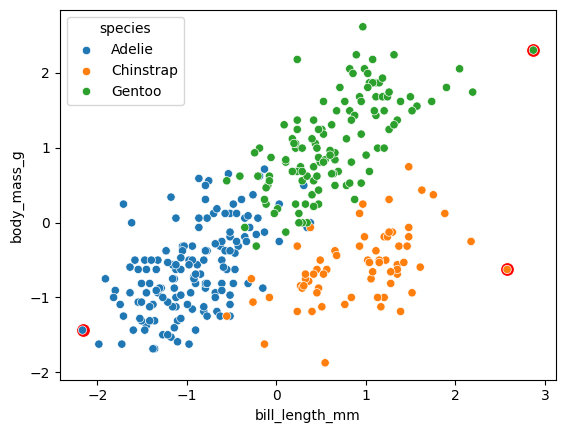

In [8]:
# Generate the archetypes
H = res["inferred_quantities"]["B"] @ X

X_df["species"] = penguins["species"]

# plot the archetypes together to this scatterplot in the same plots, and connect them by a triangle
sns.scatterplot(x=H[:,0], y=H[:,1], color='red', s=100)
sns.scatterplot(data=X_df, x="bill_length_mm", y="body_mass_g", hue="species")

### MIDAA

MIDAAs' idea is to expand this reasoning to multimodal data with an arbitrary number of features. What we do is to first is to perform a step of dimensionality reduction using a modality specific autoencoder, for each modality. We then concatenate the last layer embedding and 

<img src="architecture_scheme.png" width=797 height=355 />




The previous formulation had two problems, the first being that not the loss of reconstruction of archetypes needed to be manually weighted. This value is highly specific to the dataset and in general choosing one that is too small will result in us having inferred archetypes that are far from those actually used for reconstruction, one that is too large will cause the model to ignore the autoencoder loss. Furthermore, by fixing the plexus in latent space, we assume that the distance between the archetypes is the same (in latent space). This is not necessarily a problem if the decoder is flexible enough, but it makes the interpretation of latent space problematic when we want to interpret it. For this reason, in MIDAA we use a different formulation of latent space and one more similar to a classical VAE. Specifically, our encoder also generates a latent space $Z$ (that in this case in not a simplex). We then solve the usual archetypal analysis problem in this latent space:
```{math}
Z^{*} = ABZ
```

We then reconstruct the input and eventual side information with the usual decoder. To regularize the latent space we constrain $Z$ to live in an hypercube of dimension $[-1,1]^{K-1}$ where $K$ is the number of archetypes (more info and benchmarks in the paper*).

So let's fit this model to our penguins data.

In [9]:
import midaa as maa
import numpy as np

# More information on what that is in other tutorials
res = maa.fit_MIDAA(
    [X],
    [np.ones(X.shape[0])],
    ["G"],    
    hidden_dims_enc_ind = [128], # Hidden dimensions of the encoder
    hidden_dims_enc_common = [64], # Hidden dimensions of the encoder
    hidden_dims_enc_pre_Z = [32], # Hidden dimensions of the encoder before the Z layer
    hidden_dims_dec_common = [32], # Hidden dimensions of the decoder
    hidden_dims_dec_last = [64, 128], # Hidden dimensions of the decoder last layer
    lr = 0.01, # Learning rate
    steps = 300,
    linearize_decoder=True, # space is super simple we don't need non-linearities
    linearize_encoder = True,# space is super simple we don't need non-linearities
    narchetypes = 3,
    batch_size = 512,
    CUDA = True
    )

ELBO: 2578.61450  : 100%|██████████| 300/300 [00:03<00:00, 89.59it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


While this is just a single instance of the model, it looks like our formulation in this case tend to care less about outliers and generate archetypes that are closer to the actual sample space.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

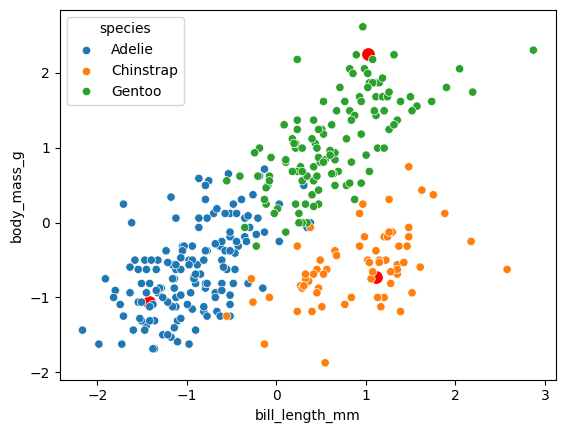

In [10]:
# Generate the archetypes
H = res["inferred_quantities"]["B"] @ X

X_df["species"] = penguins["species"]

# plot the archetypes together to this scatterplot in the same plots, and connect them by a triangle
sns.scatterplot(x=H[:,0], y=H[:,1], color='red', s=100)
sns.scatterplot(data=X_df, x="bill_length_mm", y="body_mass_g", hue="species")